In [1]:
from pyspark.sql.types import StructType, StructField, StringType, LongType
jsonSchema = StructType([
    StructField('label', StringType(), True),
    StructField('tweet_id', LongType(), True),
    StructField('tweet_text', StringType(), True)
])

#replace the file path
df=spark.read.format("json").schema(jsonSchema).load("/Users/Pavel/Documents/KULeuven/Courses/AdvancedAnalyticsinBigDataWorld/spark/data/*")

## Text preprocessing

In [4]:
import pyspark.sql.functions as f
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import ltrim

#Converting all letters to lowercase
df = df.withColumn("tweet_text",f.lower(f.col("tweet_text")))

#removing punctuations, numbers, http and spaces
df =df.withColumn("tweet_text",f.regexp_replace(f.col("tweet_text"),'([^ a-zA-Z\'])',''))
df = df.withColumn("tweet_text",f.regexp_replace(f.col("tweet_text"),'http.*?\\b',' '))
df = df.withColumn("tweet_text",f.ltrim(f.regexp_replace(f.col("tweet_text"),'[\r\n\t\f\v ]+', ' ')))



In [5]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

#Splitting words
tokenizer = Tokenizer(inputCol="tweet_text", outputCol="words")
dataset = tokenizer.transform(df)


In [6]:
#Lemmatization
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
#just to try if it works

In [7]:
## Didn't manage to apply lemmatization while using WordNetLemmatizer on pyspark dataframe. 
#So temporarily to make it work, firstly changed to pandas dataframe and then back to pyspark dataframe.

In [8]:
pandas_df = dataset.select("*").toPandas()

In [9]:

pandas_df['lemmatized'] = pandas_df['words'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])
pandas_df['lemmatized']

0        [joebiden, homeland, defense, is, not, genocid...
1        [could, be, a, messan, all, out, war, of, the,...
2        [infectious, disease, designated, bed, drastic...
3                         [do, u, truly, trust, safety, i]
4                                          [do, u, use, q]
                               ...                        
61003                                         [is, boring]
61004                                              [today]
61005                                           [go, home]
61006                                          [fuck, you]
61007                                             [thanks]
Name: lemmatized, Length: 61008, dtype: object

In [11]:
dataset2 = spark.createDataFrame(pandas_df)

In [12]:
#Removing stop words
stopwordList = ["u","ur", "amp"] 
stopwordList.extend(StopWordsRemover().getStopWords())
remover = StopWordsRemover(inputCol="lemmatized", outputCol="filtered" ,stopWords=stopwordList)
dataset2 = remover.transform(dataset2)

In [13]:
#to get rid of words like v, q, wa
dataset2 = dataset2.withColumn("filtered2", f.expr("filter(filtered, x -> not(length(x) < 3))")).where(f.size(f.col("filtered2")) > 0).drop("filtered")
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|           filtered2|
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|        #biden|1386026144328192004|joebiden homeland...|[joebiden, homela...|[joebiden, homela...|[joebiden, homela...|
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|[messan, war, world]|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|[infectious, dise...|
|      #vaccine|1381494016211030016|do u truly trust ...|[do, u, truly, tr...|[do, u, truly, tr...|[truly, trust, sa...|
|        #covid|1380766615189479425|         do u use q |     [do, u, use, q]|     [do, u, use, q]|               [use]|
|        #biden|1380129673443696

## Bag of words

In [14]:
#Vectorizing and IDF

from pyspark.ml.feature import CountVectorizer, StringIndexer, IDF, HashingTF
from pyspark.ml import Pipeline


cv = CountVectorizer(inputCol="filtered2", outputCol="tf_features")
idf = IDF(inputCol = "tf_features", outputCol = "tf_idf_features")
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "labelIndex")

pipeline = Pipeline(stages=[cv, idf, label_stringIdx])

pipelineFit = pipeline.fit(dataset2)
dataset2= pipelineFit.transform(dataset2)
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|           filtered2|         tf_features|     tf_idf_features|labelIndex|
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        #biden|1386026144328192004|joebiden homeland...|[joebiden, homela...|[joebiden, homela...|[joebiden, homela...|(76731,[16,22,247...|(76731,[16,22,247...|       3.0|
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|[messan, war, world]|(76731,[13,123,69...|(76731,[13,123,69...|       2.0|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|[infectious, dise...|(76731,[29

In [21]:
dataset2.select("label", "filtered2").show(truncate=False)

+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label         |filtered2                                                                                                                                                                                                                                                                                                  

## Train and test split

In [22]:
(trainingData2, testData2) = dataset2.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData2.count()))
print("Test Dataset Count: " + str(testData2.count()))

Training Dataset Count: 42585
Test Dataset Count: 18328


## Logistic Regression

In [23]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "labelIndex", featuresCol = "tf_idf_features", maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData2)
lrPredictions = lrModel.transform(testData2)

In [14]:
lrPredictions.select("prediction", "labelIndex").show()

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       4.0|
|       2.0|       4.0|
|       4.0|       4.0|
|       1.0|       4.0|
|       0.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       1.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
+----------+----------+
only showing top 20 rows



In [24]:
import pyspark.sql.functions as col
lrPredictions.groupBy("prediction").count().orderBy(f.col("count").desc()).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 6123|
|       1.0| 4967|
|       2.0| 3631|
|       3.0| 2247|
|       4.0| 1267|
|       5.0|   93|
+----------+-----+



### Evaluation

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lrPredictions)
print(accuracy)
print("Test Error = %g " % (1.0 - accuracy))

0.6436599738105631
Test Error = 0.35634 


In [25]:
trainingSummary = lrModel.summary

print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.04181217555450684
label 1: 0.021555179478044
label 2: 0.0034482758620689655
label 3: 0.0006309148264984228
label 4: 0.0018764659890539485
label 5: 0.0
True positive rate by label:
label 0: 0.9682270191608052
label 1: 0.9553136637066743
label 2: 0.954031117397454
label 3: 0.9421000981354269
label 4: 0.91701244813278
label 5: 0.7967741935483871
Precision by label:
label 0: 0.9001127395715897
label 1: 0.9323455409561084
label 2: 0.9850310332238043
label 3: 0.995850622406639
label 4: 0.9866071428571429
label 5: 1.0
Recall by label:
label 0: 0.9682270191608052
label 1: 0.9553136637066743
label 2: 0.954031117397454
label 3: 0.9421000981354269
label 4: 0.91701244813278
label 5: 0.7967741935483871
F-measure by label:
label 0: 0.9329282542650151
label 1: 0.94368986983588
label 2: 0.9692832764505119
label 3: 0.968229954614221
label 4: 0.9505376344086022
label 5: 0.8868940754039497
Accuracy: 0.9484984372876749
FPR: 0.017821448997847135
TPR: 0.9484984372876

In [27]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Make predicitons
predictionAndTarget = lrPredictions.select("prediction", "labelIndex")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)

In [29]:
evaluatorMulti.evaluate(predictionAndTarget) #gives F1 score


0.6429010767199942

In [30]:
print("ACC: %s" % acc)
print("F1 score: %s" % f1)
print("Weighted Precision: %s" % weightedPrecision)
print("Weighted Recall: %s" % weightedRecall)
print("AUC: %s" % auc)

ACC: 0.6436599738105631
F1 score: 0.6429010767199942
Weighted Precision: 0.6710119769570125
Weighted Recall: 0.6436599738105631
AUC: 0.6436599738105631


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
from sklearn.metrics import confusion_matrix
y_true = lrPredictions.select("labelIndex")
y_true = y_true.toPandas()

y_pred = lrPredictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix


array([[3389,  938,  152,  103,   14,    2],
       [1354, 2891,  254,  148,   28,    0],
       [ 505,  428, 2640,  222,   23,    3],
       [ 477,  364,  364, 1630,   41,    1],
       [ 288,  228,  114,  104, 1160,    0],
       [ 110,  118,  107,   40,    1,   87]])

Confusion matrix, without normalization
[[3389  938  152  103   14    2]
 [1354 2891  254  148   28    0]
 [ 505  428 2640  222   23    3]
 [ 477  364  364 1630   41    1]
 [ 288  228  114  104 1160    0]
 [ 110  118  107   40    1   87]]


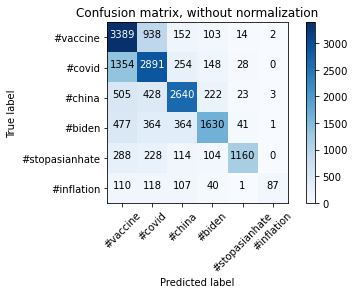

In [41]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=pipelineFit.stages[2].labels,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[7.37059591e-01 2.04001740e-01 3.30578512e-02 2.24010439e-02
  3.04480209e-03 4.34971727e-04]
 [2.89625668e-01 6.18395722e-01 5.43315508e-02 3.16577540e-02
  5.98930481e-03 0.00000000e+00]
 [1.32164355e-01 1.12012562e-01 6.90918608e-01 5.80999738e-02
  6.01936666e-03 7.85134781e-04]
 [1.65797706e-01 1.26520681e-01 1.26520681e-01 5.66562391e-01
  1.42509559e-02 3.47584289e-04]
 [1.52059134e-01 1.20380148e-01 6.01900739e-02 5.49102429e-02
  6.12460401e-01 0.00000000e+00]
 [2.37580994e-01 2.54859611e-01 2.31101512e-01 8.63930886e-02
  2.15982721e-03 1.87904968e-01]]


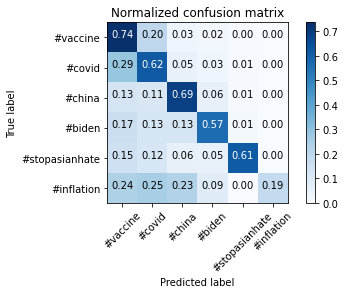

In [44]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=pipelineFit.stages[2].labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()